In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras import Sequential
from keras.layers import Dense
from keras.metrics import AUC
import keras.backend as K
import tensorflow as tf
import os


In [2]:
EMB_PATH = "../../data/embeddings/efficient_net/decision_clf_enh/"
MODEL_NAME = "decision_enh_all"

MODEL_PATH = f"../models/{MODEL_NAME}/"
classes = ["Urgent Treatment", "Follow Up", "Discharge"]
k = 5

In [3]:
# loads numpy array of dimensions: X - (num_images, 1280, 1), y - (num_images, num_classes)
files = sorted(os.listdir(EMB_PATH))
X = np.load(f"{EMB_PATH}{files[0]}")  
y = np.load(f"{EMB_PATH}{files[1]}")
input_dim = X.shape[1]

# 70-20-10 split of data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [4]:
print("Train set: ", X_train.shape, y_train.shape)
print("Test set: ", X_test.shape, y_test.shape)

Train set:  (63274, 1280, 1) (63274, 3)
Test set:  (7031, 1280, 1) (7031, 3)


In [5]:
num_classes = y.shape[1]

In [6]:
def k_folds_split(X, y, n=1):
    p = np.random.permutation(len(X))
    X, y = X[p], y[p]
    x_split = np.array_split(X, n)
    y_split = np.array_split(y, n)
    return (x_split, y_split)

In [7]:
def k_folds_join(X, y, ind=0):
    n = len(X)
    train_x, train_y = None, None
    test_x, test_y = X[ind], y[ind]

    for i in range(n):
        if i != ind:
            if type(train_x) != np.ndarray:
                train_x, train_y = X[i], y[i]
            else:
                train_x = np.concatenate((train_x, X[i]))
                train_y = np.concatenate((train_y, y[i]))
    
    return (train_x, train_y), (test_x, test_y)

In [8]:
def sensitivity(y_true, y_pred):     
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):    
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [9]:
def kfolds_train(X, y, k):
    results = []
    X_split, y_split = k_folds_split(X, y, k) 

    for i in range(k):
        (X_train, y_train), (X_val, y_val) = k_folds_join(X_split, y_split, i)

        model = Sequential([
            Dense(1024, input_dim=input_dim, activation='relu'),
            Dense(1024, activation='relu'),
            Dense(num_classes, activation='softmax')
        ])

        model.compile(loss='categorical_crossentropy', optimizer='adam', 
            metrics=['accuracy',  AUC(name='AUC'), sensitivity, specificity])

        model.fit(X_train, y_train, epochs=20, batch_size=128, validation_data=(X_val, y_val))

        result = model.evaluate(X_test, y_test)
        results.append(result)
    
    return model, results

In [10]:
def train(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=2/9)
    
    model = Sequential([
            Dense(1024, input_dim=input_dim, activation='relu'),
            Dense(1024, activation='relu'),
            Dense(num_classes, activation='softmax')
        ])

    model.compile(loss='categorical_crossentropy', optimizer='adam', 
        metrics=['accuracy',  AUC(name='AUC'), sensitivity, specificity])

    model.fit(X_train, y_train, epochs=30, batch_size=128, validation_data=(X_val, y_val))

    results = model.evaluate(X_test, y_test)
    return model, results

In [11]:
model, results = kfolds_train(X_train, y_train, k)
# model, results = train(X_train, y_train)

Epoch 1/20
396/396 [==============================] - 9s 11ms/step - loss: 0.5948 - accuracy: 0.7366 - AUC: 0.8935 - sensitivity: 0.7321 - specificity: 0.8706 - val_loss: 0.5691 - val_accuracy: 0.7557 - val_AUC: 0.9089 - val_sensitivity: 0.7497 - val_specificity: 0.8806
Epoch 2/20
396/396 [==============================] - 3s 8ms/step - loss: 0.5595 - accuracy: 0.7506 - AUC: 0.9049 - sensitivity: 0.7484 - specificity: 0.8763 - val_loss: 0.5563 - val_accuracy: 0.7557 - val_AUC: 0.9093 - val_sensitivity: 0.7548 - val_specificity: 0.8782
Epoch 3/20
396/396 [==============================] - 3s 8ms/step - loss: 0.5505 - accuracy: 0.7534 - AUC: 0.9078 - sensitivity: 0.7510 - specificity: 0.8778 - val_loss: 0.5407 - val_accuracy: 0.7655 - val_AUC: 0.9145 - val_sensitivity: 0.7625 - val_specificity: 0.8847
Epoch 4/20
396/396 [==============================] - 3s 8ms/step - loss: 0.5437 - accuracy: 0.7579 - AUC: 0.9101 - sensitivity: 0.7556 - specificity: 0.8799 - val_loss: 0.5545 - val_accura

In [12]:
def display_kfolds_results(results):
    mean_results = [0 for i in range(len(results[0]))]
    for i in range(k):
        for j in range(len(results[i])):
            mean_results[j] += results[i][j]
        print(f"Model {i+1}: {results[i][1]:.4f} (accuracy) {results[i][2]:.4f} (AUC) {results[i][3]:.4f} (sensitivity) {results[i][4]:.4f} (specificity)")

    mean_results = [i/k for i in mean_results]
    print(f"\nMean: {mean_results[1]:.4f} (accuracy) {mean_results[2]:.4f} (AUC) {mean_results[3]:.4f} (sensitivity) {results[i][4]:.4f} (specificity)")

In [13]:
display_kfolds_results(results)

Model 1: 0.7791 (accuracy) 0.9227 (AUC) 0.7780 (sensitivity) 0.8903 (specificity)
Model 2: 0.7771 (accuracy) 0.9224 (AUC) 0.7764 (sensitivity) 0.8887 (specificity)
Model 3: 0.7703 (accuracy) 0.9199 (AUC) 0.7687 (sensitivity) 0.8856 (specificity)
Model 4: 0.7800 (accuracy) 0.9242 (AUC) 0.7788 (sensitivity) 0.8908 (specificity)
Model 5: 0.7815 (accuracy) 0.9225 (AUC) 0.7789 (sensitivity) 0.8920 (specificity)

Mean: 0.7776 (accuracy) 0.9223 (AUC) 0.7762 (sensitivity) 0.8920 (specificity)


In [14]:
probs = model.predict(X_test)
predictions = [np.argmax(i) for i in probs]
labels = [np.argmax(i) for i in y_test]

res = tf.math.confusion_matrix(labels, predictions)

220/220 [==============================] - 1s 2ms/step


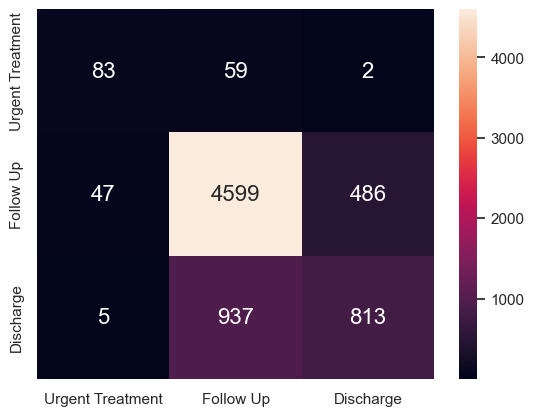

In [15]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

# classes = sorted(list(set(labels)))

array = np.array(res).tolist()
df_cm = pd.DataFrame(array, classes, classes)
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')

plt.show()

In [16]:
def store_results(results):
    res_path = f'{MODEL_PATH}{MODEL_NAME}.csv'

    d = {'accuracy':[], 'AUC':[], 'sensitivity':[], 'specificity':[]}

    for i in range(len(results)):
        d['accuracy'].append(f"{100 * results[i][1]:.2f}")
        d['AUC'].append(f"{100 * results[i][2]:.2f}")
        d['sensitivity'].append(f"{100 * results[i][3]:.2f}")
        d['specificity'].append(f"{100 * results[i][4]:.2f}")

    df = pd.DataFrame(d)
    df.to_csv(res_path)

In [17]:
store_results(results)

In [18]:
model.save(f"{MODEL_PATH}{MODEL_NAME}.h5")